In [2]:
# Chargement du script raster_tools (un module - et pour l'instant l'unique - du package telenvi)
import os
import raster_tools as rt

---------
telenvi package 3.0.7
---------


In [3]:
# Définition des chemins vers les cibles d'intérêt pour nos tests
path_im_sentinel = "/hello/CAM-RANH_2022_06_21_S2A/T49PBP_20220621T030551_B04.jp2"
path_im_landsat = "/hello/CAM-RANH_2011_10_30_LS8/LT05_L2SP_123052_20111030_20200820_02_T1_SR_B4.TIF"

In [4]:
im_landsat = rt.openGeoRaster(path_im_landsat)

geoim from file LT05_L2SP_123052_20111030_20200820_02_T1_SR_B4.TIF ready


pixel size : (30.0, -30.0)
origin     : (236985.0, 1293615.0)
bands      : 1
rows       : 1500
columns    : 2000
SCR epsg   : 32649
SCR name   : WGS 84 / UTM zone 49N



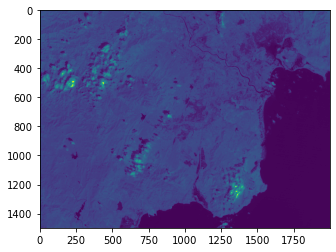

In [5]:
"""
section : découpage de l'image
Il y a 3 manières de découper un GeoIm, opération couramment appelée "crop". 
"""

"""
1 - découpage depuis des indexs matriciel
Comme vous le savez peut-être, une image peut être considérée comme un tableau, ou plutôt une "matrice". 
Donc avec n lignes, et n colonnes. Il est ainsi possible de découper un GeoIm en formulant le souhait 
de ne conserver que la partie conservée entre la n ième ligne et la n+x ième ligne, et pareil pour les colonnes.
On dit que ces coordonnées sont ainsi exprimées dans le référentiel matriciel de l'image.
"""

cutA = im_landsat.cropFromIndex( row1 = 3000, row2 = 4500, col1 = 1000, col2 = 3000)
print(cutA)
cutA.quickVisual()

pixel size : (30.0, -30.0)
origin     : (306765.0, 1321785.0)
bands      : 1
rows       : 107
columns    : 114
SCR epsg   : 32649
SCR name   : WGS 84 / UTM zone 49N



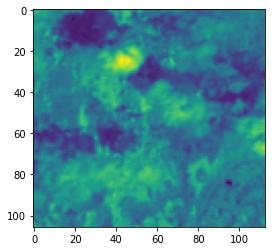

In [6]:
"""
2 - découpage depuis un polygone vectoriel
Toute portion d'espace peut être décrite grâce à des objets vectoriels. 
L'élément primaire d'un tel objet est le point, lui-même décrit par une coordonnée X et une coordonée Y.
Il est possible d'assembler ces points au sein d'une suite, pour former des lignes et des polygones. 
"""

import shapely

"""
Les éléments géographiques OGR ou shapely que nous avons vus précédemment - dont on se sert pour
décrire l'étendue d'un GeoIm - sont des vecteurs. Ainsi, nous pouvons nous en servir pour décrire
une zone sur laquelle on aimerait découper un GeoIm. 
"""

# Construisons d'abord un vecteur polygone à partir d'une liste de points que nous aurions
# préalablement relevé
points = [(306782.0,1321770.4), (310193.0,1320325.9), (310092.9,1318559.6), (306932.2,1319260.4)]
vector = shapely.geometry.Polygon(points)

# On peut maintenant ordonner un découpage de notre image landsat à partir de ce vecteur
cutB = im_landsat.cropFromVector(vector)

# Observons maintenant le résultat
print(cutB)
cutB.quickVisual()

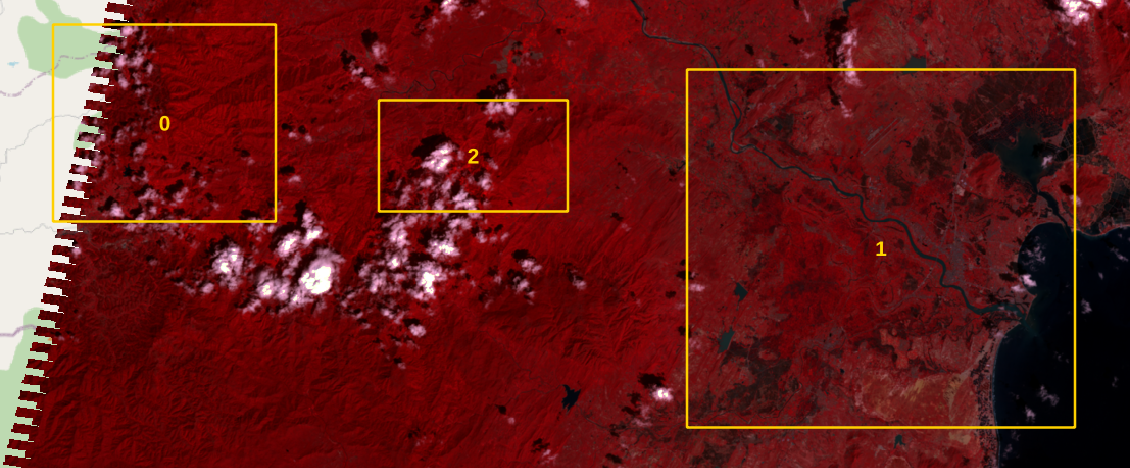

In [7]:
"""
Les shapefiles sont, quant à eux, des fichiers contenants une ou plusieurs entités vectorielles. 
Les SIG bureautiques tels que QGIS ou ArcGis permettent de les manipuler de manière graphique. 
Et la bonne nouvelle, c'est qu'on peut également s'en servir pour découper un GeoIm.
"""

"""
Considérons le shapefile zones_interet.shp : 
Il contient 3 polygones différents, identifiés par leur "ordre" dans la table attributaire.
La figure ci-dessous illustre ce shapefile et ses différents polygones et permet de localiser 
chaque entité par rapport à l'image chargée dans le GeoIm im_landsat, affichée ici en composition
colorée infrarouge (la végétation apparaît en rouge).
"""
from PIL import Image
Image.open("/hello/CAM-RANH_2011_10_30_LS8/zones_interet.png")

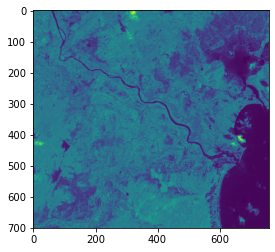

In [8]:
# Découpage selon différents polygones contenus dans un seul et même shapefile
cutC = im_landsat.cropFromVector(
    "/hello/CAM-RANH_2011_10_30_LS8/zones_interet.shp",
    polygon = 0)

cutD = im_landsat.cropFromVector(
    "/hello/CAM-RANH_2011_10_30_LS8/zones_interet.shp",
    polygon = 1)

cutE = im_landsat.cropFromVector(
    "/hello/CAM-RANH_2011_10_30_LS8/zones_interet.shp",
    polygon = 2)

# Observation du résultat
cutD.quickVisual()

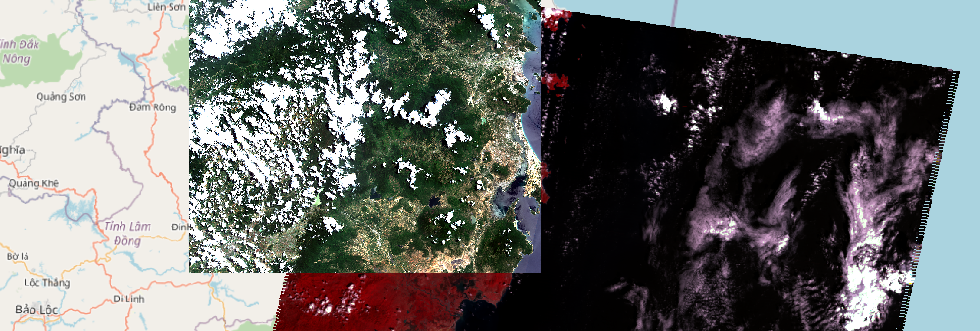

In [9]:
"""
Pour terminer, on peut également découper une image selon l'emprise d'une autre image.
Ou plutôt, sur son emprise commune avec une autre image. 
Considérons le cas suivant : Nous disposons de deux fichiers rasters, que nous 
aimerions pouvoir comparer. La figure ci-dessous permet de visualiser la position 
relative des deux fichiers rasters, et leur zone de chevauchement. 
"""
Image.open("/hello/CAM-RANH_2011_10_30_LS8/chevauchement.png")

pixel size : (30.0, -30.0)
origin     : (206985.0, 1383615.0)
bands      : 1
rows       : 3112
columns    : 3426
SCR epsg   : 32649
SCR name   : WGS 84 / UTM zone 49N



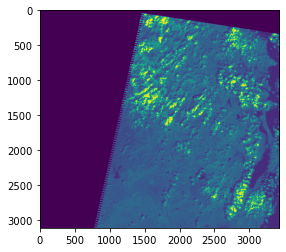

In [10]:
"""
Crop d'un GeoIm en fonction d'un fichier raster
"""
cutF = im_landsat.cropFromRaster("/hello/CAM-RANH_2022_06_21_S2A/T49PBP_20220621T030551_B04.jp2")
print(cutF)
cutF.quickVisual()

# La fonction cropFromRaster détecte la zone de chevauchement et renvoie un nouveau GeoIm
# avec les données du premier GeoIm sur rcette zone de chevauchement.

v0.tif ok
v1.tif ok
v2.tif ok
v3.tif ok


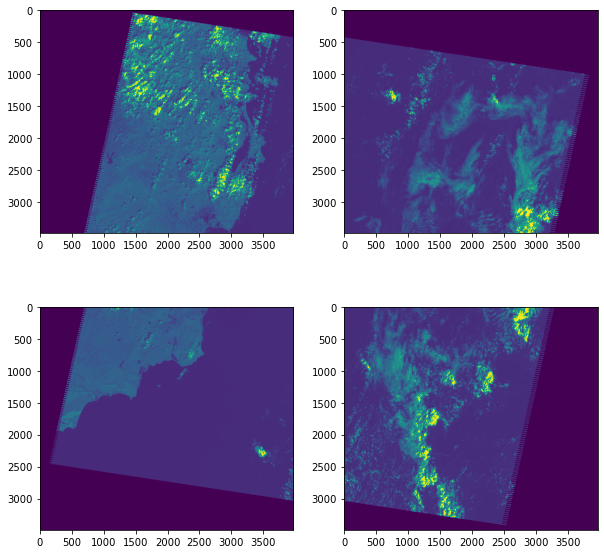

In [11]:
"""
Une mosaïque peut être définie comme un ensemble de formes qui, mises côté à côté,
forment un motif d'ensemble.

En télédétection, on a parfois besoin d'en créer une à partir d'une image satellite.
Les raisons sont nombreuses : 
    - construction d'une base de données d'apprentissage de machine learning, 
    - diverses problématiques d'analyse spatiale
    - optimisation de traitements lourds en traitant successivement ou parrallèlement
      de petites portions d'une seule et même image

Et c'est pour cela que les GeoIm sont dotés d'une méthode makeMosaic() qui divise leur
image en une mosaïque. Il faut spécifier le nombre de vignettes à créer en ligne, et en colonnes.

Voyons-voir comment ça fonctionne.
"""

# Comportement par défaut : 
# découpe l'image en 4 vignettes. 2 selon l'axe X, et 2 selon l'axe Y.
mosaic1 = im_landsat.makeMosaic()

# 10 vignettes en Y, 3 en X
mosaic2 = im_landsat.makeMosaic(thumbsY = 10, thumbsX = 3)

# Illustration du comportement par défaut
from matplotlib import pyplot as plt
plt.figure(figsize=(10,10))
for i, thumb in enumerate(mosaic1):
  plt.subplot(2,2,i+1)
  plt.imshow(thumb.array)
  
# Ensuite, les différents mini-GeoIm sont contenus dans la liste retournée par la méthode makeMosaic().
# Il est possible de les sauvegarder tous sur son ordinateur avec une instruction du style :
for i, thumb in enumerate(mosaic1):
  thumb.save(f"/hello/CAM-RANH_2011_10_30_LS8/v{i}.tif")

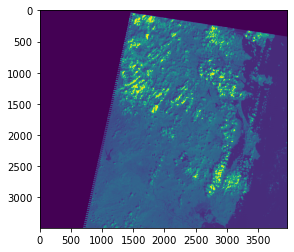

In [13]:
"""
Profitons du fait qu'on aie plusieurs GeoIm pour voir une autre de leur fonctionnalité : le merge.
On peut ajouter d'autres GeoIms à un GeoIm, pour n'en former qu'un seul, "plus grand". 
"""

# Extraction d'un seul des 4 GeoIm contenus dans la liste "mosaic1"
v0 = mosaic1[0]

# merge avec les 3 autres
v0.merge(mosaic1[1:])

# Visualisation du résultat
v0.quickVisual()
